# Multi-Fidelity Bayesian Optimization

This notebook contains an example of using Emukit to perform Bayesian optimization on a function where low-fidelity approximations are availalbe. 

The high fidelity function to be optimized is the forreseter function given by: 

$$
f_{high}(x) = (6x - 2)^2 \sin(12x - 4)
$$

The low fidelity approximation of this function is given by:

$$
f_{low}(x) = 0.5 f_{high}(x) + 10 (x - 0.5) + 5
$$

Both are defined in the interval [0, 1].

Each evaluation of the high fidelity function costs $5$ units, whereas evaluating the low fidelity function costs $1$.

We wish to find the location of the maximum of $f_{high}$ while taking advantage of the cheaper to evaluate $f_{low}$.

In [1]:
# Load function
import emukit.test_functions.forrester

# The multi-fidelity Forrester function is already wrapped as an Emukit UserFunction object in 
# the test_functions package
forrester_fcn, _ = emukit.test_functions.forrester.multi_fidelity_forrester_function()
forrester_fcn_low = forrester_fcn.f[0]
forrester_fcn_high = forrester_fcn.f[1]

# Assign costs
low_fidelity_cost = 1
high_fidelity_cost = 5

## Plot Functions

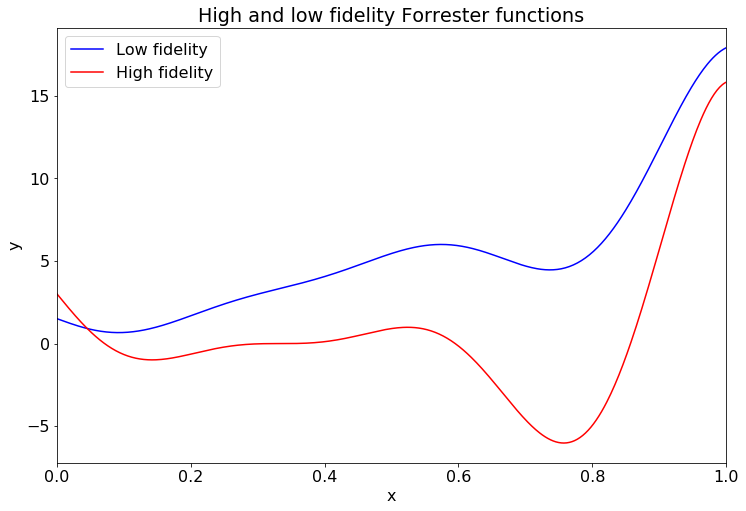

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
FIG_SIZE = (12, 8)
import numpy as np
np.random.seed(12345)
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array

n_plot_points = 100
x_plot = np.linspace(0, 1, 500)[:, None]
y_plot_low = forrester_fcn_low(x_plot)
y_plot_high = forrester_fcn_high(x_plot)

plt.figure(figsize=FIG_SIZE)
plt.plot(x_plot, y_plot_low, 'b')
plt.plot(x_plot, y_plot_high, 'r')
plt.legend(['Low fidelity', 'High fidelity'])
plt.xlim(0, 1)
plt.title('High and low fidelity Forrester functions')
plt.xlabel('x')
plt.ylabel('y');

## Bayesian optimization

### Define Parameter Space

The parameter space now contains two parameters: the first is a `ContinuousParameter` that is the $x$ input to the Forrester function. The second is an `InformaionSourceParameter` that tells Emukit whether a given fucntion evaluation is to be performed by the high or low fidelity function.

In [3]:
from emukit.core import ParameterSpace, ContinuousParameter, InformationSourceParameter
n_fidelities = 2

parameter_space = ParameterSpace([ContinuousParameter('x', 0, 1), InformationSourceParameter(n_fidelities)])

### Generate Initial Data

We shall randomly choose 12 low fidelity and then choose 6 of these points at which to evaluate the high fidelity function.

In [4]:
x_low = np.random.rand(6)[:, None]
x_high = x_low[:3, :]

y_low = forrester_fcn_low(x_low)
y_high = forrester_fcn_high(x_high)

### Define Model

We will use the linear multi-fidelity model defined in Emukit. In this model, the high-fidelity function is modelled as a scaled sum of the low-fidelity function plus an error term:

$$
f_{high}(x) = f_{err}(x) + \rho \,f_{low}(x)
$$

In [5]:
from emukit.multi_fidelity.models.linear_model import GPyLinearMultiFidelityModel
import GPy
from emukit.multi_fidelity.kernels.linear_multi_fidelity_kernel import LinearMultiFidelityKernel
from emukit.multi_fidelity.convert_lists_to_array import convert_xy_lists_to_arrays
from emukit.model_wrappers import GPyMultiOutputWrapper

x_array, y_array = convert_xy_lists_to_arrays([x_low, x_high], [y_low, y_high])

kern_low = GPy.kern.RBF(1)
kern_low.lengthscale.constrain_bounded(0.01, 1.)

kern_err = GPy.kern.RBF(1)
kern_err.lengthscale.constrain_bounded(0.01, 1.)

multi_fidelity_kernel = LinearMultiFidelityKernel([kern_low, kern_err])
gpy_model = GPyLinearMultiFidelityModel(x_array, y_array, multi_fidelity_kernel, n_fidelities)
gpy_model.likelihood.Gaussian_noise.fix(1e-6)
gpy_model.likelihood.Gaussian_noise_1.fix(1e-6)

model = GPyMultiOutputWrapper(gpy_model, 2, 5, verbose_optimization=False)
model.optimize()

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


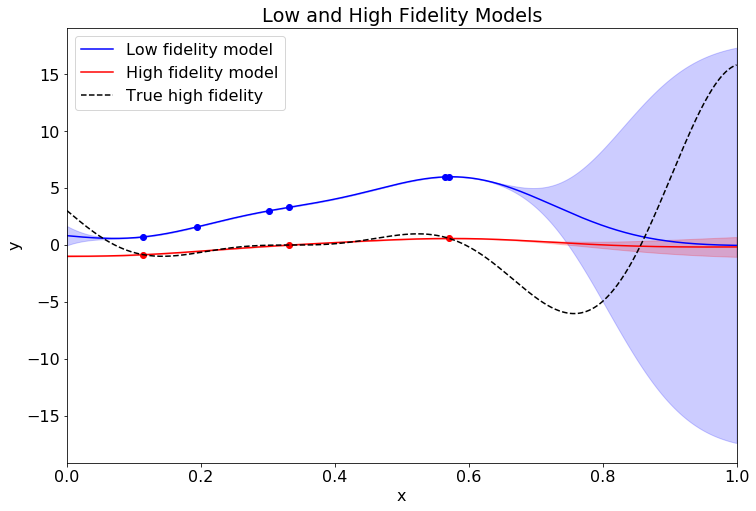

In [6]:
x_plot_low = np.concatenate([np.atleast_2d(x_plot), np.zeros((x_plot.shape[0], 1))], axis=1)
x_plot_high = np.concatenate([np.atleast_2d(x_plot), np.ones((x_plot.shape[0], 1))], axis=1)

mean_low, var_low = model.predict(x_plot_low)
mean_high, var_high = model.predict(x_plot_high)

plt.figure(figsize=FIG_SIZE)
def plot_with_error_bars(x, mean, var, color):
    plt.plot(x, mean, color=color)
    plt.fill_between(x.flatten(), mean.flatten() - 1.96*var.flatten(), mean.flatten() + 1.96*var.flatten(), 
                    alpha=0.2, color=color)

plot_with_error_bars(x_plot_high[:, 0], mean_low, var_low, 'b')
plot_with_error_bars(x_plot_high[:, 0], mean_high, var_high, 'r')
plt.plot(x_plot, forrester_fcn_high(x_plot), 'k--')
plt.scatter(x_low, y_low, color='b')
plt.scatter(x_high, y_high, color='r')
plt.legend(['Low fidelity model', 'High fidelity model', 'True high fidelity'])
plt.title('Low and High Fidelity Models')
plt.xlim(0, 1)
plt.xlabel('x')
plt.ylabel('y');

### Define Acquisition Function

As in [1] & [2] we shall use the entropy search acquisition function, scaled by the cost of evaluating either the high or low fidelity function.

In [7]:
from emukit.bayesian_optimization.acquisitions.entropy_search import MultiInformationSourceEntropySearch
from emukit.core.acquisition import Acquisition

# Define cost of different fidelities as acquisition function
class Cost(Acquisition):
    def __init__(self, costs):
        self.costs = costs

    def evaluate(self, x):
        fidelity_index = x[:, -1].astype(int)
        x_cost = np.array([self.costs[i] for i in fidelity_index])
        return x_cost[:, None]
    
    @property
    def has_gradients(self):
        return True
    
    def evaluate_with_gradients(self, x):
        return self.evalute(x), np.zeros(x.shape)

cost_acquisition = Cost([low_fidelity_cost, high_fidelity_cost])
acquisition = MultiInformationSourceEntropySearch(model, parameter_space) / cost_acquisition

### Create OuterLoop

In [8]:
from emukit.core.loop import FixedIntervalUpdater, OuterLoop, SequentialPointCalculator
from emukit.core.loop.loop_state import create_loop_state
from emukit.core.optimization.multi_source_acquisition_optimizer import MultiSourceAcquisitionOptimizer
from emukit.core.optimization import GradientAcquisitionOptimizer

initial_loop_state = create_loop_state(x_array, y_array)
candidate_point_calculator = SequentialPointCalculator(acquisition, GradientAcquisitionOptimizer(parameter_space))
model_updater = FixedIntervalUpdater(model)
loop = OuterLoop(candidate_point_calculator, model_updater, initial_loop_state)

### Add Plotting of Acquisition Function

To see how the acquisition function evolves. This is done by using the `iteration_end_event` on the `OuterLoop`. This is a list of functions where each function should have the signature: `function(loop, loop_state)`. All functions in the list are called after each iteration of the optimization loop.

In [9]:
def plot_acquisition(loop, loop_state):
    colours = ['b', 'r']
    plt.figure()
    plt.plot(x_plot_low[:, 0], loop.candidate_point_calculator.acquisition.evaluate(x_plot_low), 'b')
    plt.plot(x_plot_high[:, 0], loop.candidate_point_calculator.acquisition.evaluate(x_plot_high), 'r')
    
    previous_x_collected = loop_state.X[[-1], :]
    fidelity_idx = int(previous_x_collected[0, -1])
    plt.scatter(previous_x_collected[0, 0], 
                loop.candidate_point_calculator.acquisition.evaluate(previous_x_collected), 
                color=colours[fidelity_idx])
    plt.legend(['Low fidelity', 'High fidelity'], fontsize=12)
    plt.title('Acquisition Function at Iteration ' + str(loop_state.iteration))
    plt.xlabel('x')
    plt.xlim(0, 1)
    plt.ylabel('Acquisition Value')
    plt.tight_layout()
    plt.show()
    
loop.iteration_end_event.append(plot_acquisition)

### Find Esimated Minimum at Every Iteration
On each iteration of the optimization loop, find the minimum value of the high fidelity model.

In [10]:
x_search = np.stack([np.linspace(0, 1, 1000), np.ones(1000)], axis=1)

model_min_mean = []
model_min_loc = []
def calculate_metrics(loop, loop_state):
    mean, var = loop.model_updaters[0].model.predict(x_search)
    model_min_mean.append(np.min(mean))
    model_min_loc.append(x_search[np.argmin(mean), 0])

# subscribe to event
loop.iteration_end_event.append(calculate_metrics)

### Run Optimization

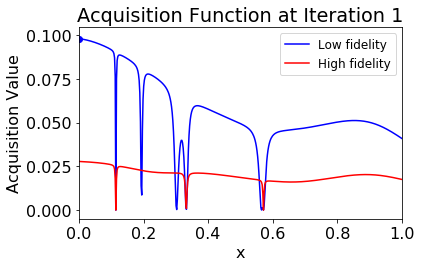

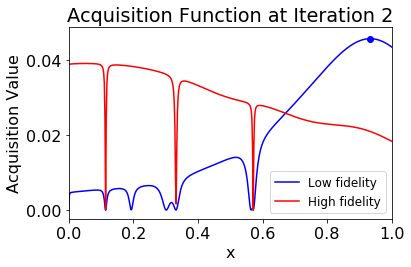

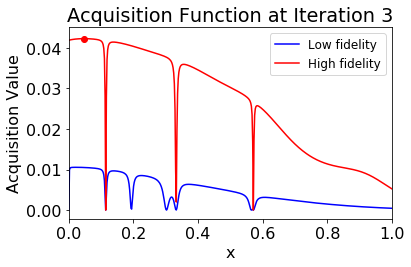

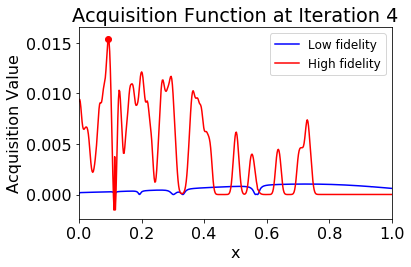

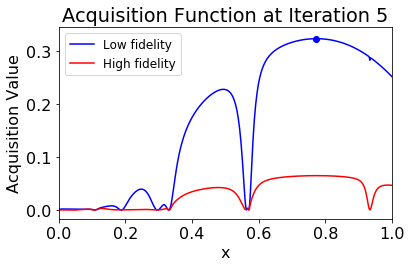

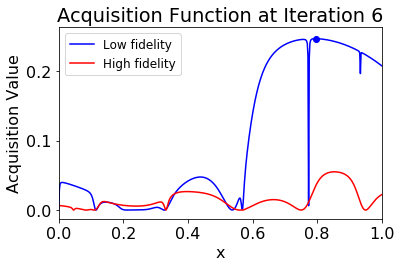

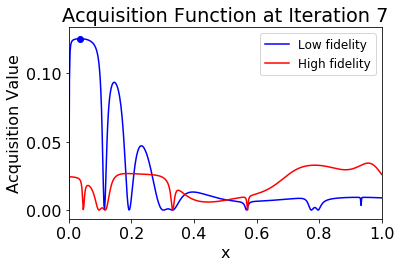

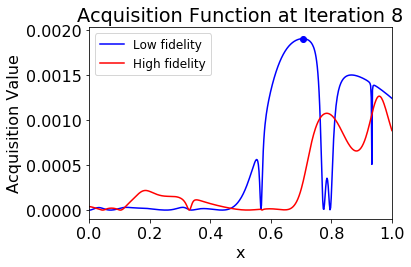

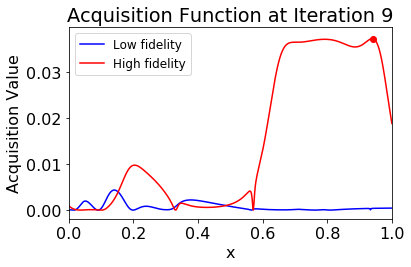

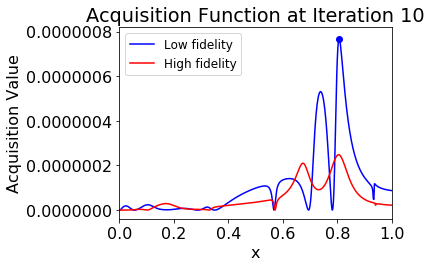

In [11]:
loop.run_loop(forrester_fcn, 10)

### Plot Final Model

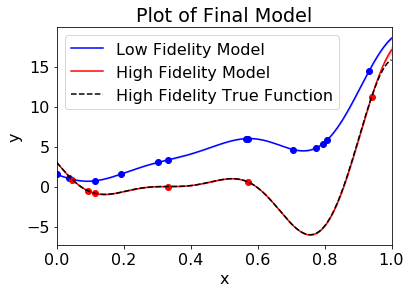

In [12]:
mean_low, var_low = model.predict(x_plot_low)
mean_high, var_high = model.predict(x_plot_high)

plt.figure()
plot_with_error_bars(x_plot_high[:, 0], mean_low, var_low, 'b')
plot_with_error_bars(x_plot_high[:, 0], mean_high, var_high, 'r')

is_high_fidelity = loop.loop_state.X[:, -1] == 1
plt.scatter(loop.loop_state.X[~is_high_fidelity, 0], loop.loop_state.Y[~is_high_fidelity], color='b')
plt.scatter(loop.loop_state.X[is_high_fidelity, 0], loop.loop_state.Y[is_high_fidelity], color='r')

plt.plot(x_plot, forrester_fcn_high(x_plot), 'k--')

plt.legend(['Low Fidelity Model', 'High Fidelity Model', 'High Fidelity True Function'])

plt.xlabel('x')
plt.xlim(0, 1)
plt.ylabel('y')
plt.title('Plot of Final Model');

## Comparison to High Fidelity Only Bayesian Optimization

This section compares the multi-fidelity optimization to Bayesian optimization using high fidelity observations only.

In [14]:
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions.entropy_search import EntropySearch
from emukit.model_wrappers import GPyModelWrapper
import GPy

# Make model
gpy_model = GPy.models.GPRegression(x_high, y_high)
gpy_model.Gaussian_noise.variance.fix(1e-6)
hf_only_model = GPyModelWrapper(gpy_model)

# Create loop
hf_only_space = ParameterSpace([ContinuousParameter('x', 0, 1)])
hf_only_acquisition = EntropySearch(hf_only_model, hf_only_spase)
hf_only_loop = BayesianOptimizationLoop(hf_only_space, hf_only_model, hf_only_acquisition)

# Calculate best guess at minimum at each iteration of loop
hf_only_model_min_mean = []
x_search = np.linspace(0, 1, 1000)[:, None]
hf_only_model_min_loc = []
def calculate_metrics(loop, loop_state):
    mean, var = loop.model_updaters[0].model.predict(x_search)
    hf_only_model_min_mean.append(np.min(mean))
    hf_only_model_min_loc.append(x_search[np.argmin(mean)])

# subscribe to event
hf_only_loop.iteration_end_event.append(calculate_metrics)

# Run optimization
hf_only_loop.run_loop(forrester_fcn_high, 10)

### Plot Estimated Minimum Location

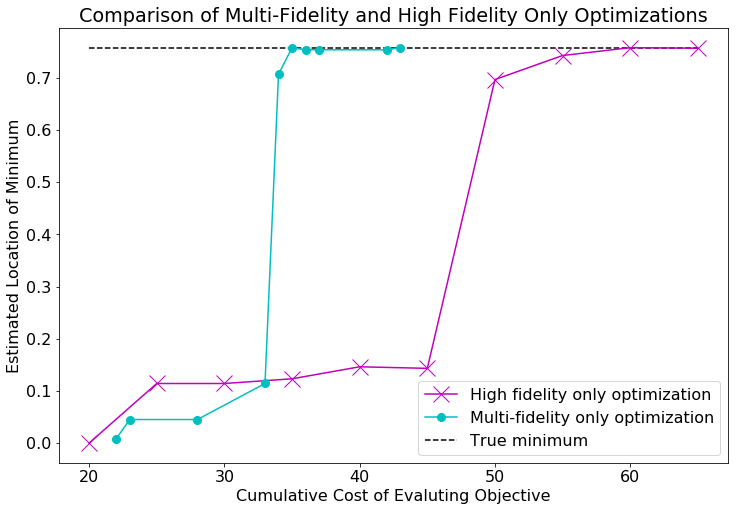

In [15]:
# Plot comparison

plt.figure(figsize=FIG_SIZE)
x = np.array(range(len(model_min_mean))) + 1

# Calculate cumulative cost of evaluating high fidelity only observations
n_hf_points = hf_only_loop.loop_state.X.shape[0]
cumulative_cost_hf = high_fidelity_cost * (np.array(range(n_hf_points)) + 1)
cumulative_cost_hf = cumulative_cost_hf[x_high.shape[0]:]

# Calculate cumulative cost of evaluating multi-fidelity observations
cost_mf = cost_acquisition.evaluate(loop.loop_state.X)
cumulative_cost_mf = np.cumsum(cost_mf)
cumulative_cost_mf = cumulative_cost_mf[x_array.shape[0]:]

x_min = np.min([cumulative_cost_hf, cumulative_cost_mf])
x_max = np.max([cumulative_cost_hf, cumulative_cost_mf])

plt.plot(cumulative_cost_hf, hf_only_model_min_loc, 'm', marker='x', markersize=16)
plt.plot(cumulative_cost_mf, model_min_loc, 'c', marker='.', markersize=16)
plt.hlines(x_search[np.argmin(forrester_fcn_high(x_search))], x_min, x_max, color='k', linestyle='--')
plt.legend(['High fidelity only optimization', 'Multi-fidelity only optimization', 'True minimum'])
plt.title('Comparison of Multi-Fidelity and High Fidelity Only Optimizations')
plt.ylabel('Estimated Location of Minimum')
plt.xlabel('Cumulative Cost of Evaluting Objective');

The multi-fidelity Bayesian optimization has used the low fidelity observations to find the true optimum of the function with a lower cost than the high-fidelity optimization needs.

# References

- **[1] Virtual vs. Real: Trading Off Simulations and Physical Experiments in Reinforcement Learning with Bayesian Optimization** Alonso Marco, Felix Berkenkamp, Philipp Hennig, Angela P. Schoellig, Andreas Krause, Stefan Schaal, Sebastian Trimpe 
- **[2] Multi-Task Bayesian Optimization** Kevin Swersky, Jasper Snoek, Ryan P. Adams